In [36]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

# from image_distribution_models import PixelCNN

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#MNIST
(patches, _), (test_patches, _) = tf.keras.datasets.mnist.load_data()
eigenvalue_floor = 1e0


In [48]:
from encoding_information.bsccm_utils import *
from encoding_information.image_utils import *

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 28
num_images = 20000
num_images = 5000

# channel = 'LED119'
channel = 'DPC_Right'
eigenvalue_floor = 1e-3

num_test_images = 500

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 5000
seed = 10

patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


Opening BSCCM
Opened BSCCM


In [1]:
from encoding_information.models.gaussian_process import StationaryGaussianProcess

stationary_gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
val_loss_history = stationary_gp.fit(patches, max_epochs=5, eigenvalue_floor=eigenvalue_floor)          

2023-10-22 15:31:54.642035: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 15:31:55.237124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

NameError: name 'stationary_gp' is not defined

In [50]:
from encoding_information.models.pixel_cnn import PixelCNN

num_hidden_channels = 64
num_mixture_components = 40

pixel_cnn = PixelCNN(num_hidden_channels=num_hidden_channels, num_mixture_components=num_mixture_components)
val_loss_history = pixel_cnn.fit(patches, max_epochs=30)          

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(val_loss_history)
clear_spines(ax)


Computing loss: 15it [00:01, 12.46it/s]


Initial validation NLL: 402.61


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 12.12it/s]
Computing loss: 15it [00:00, 77.41it/s]


Epoch 1: validation NLL: 6.08


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 30.63it/s]
Computing loss: 15it [00:00, 90.35it/s]


Epoch 2: validation NLL: 5.13


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 29.57it/s]
Computing loss: 15it [00:00, 88.36it/s]


Epoch 3: validation NLL: 5.02


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 31.36it/s]
Computing loss: 15it [00:00, 84.02it/s]


Epoch 4: validation NLL: 4.92


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 32.85it/s]
Computing loss: 15it [00:00, 94.65it/s]


Epoch 5: validation NLL: 4.87


Epoch 6: 100%|██████████| 100/100 [00:02<00:00, 34.09it/s]
Computing loss: 15it [00:00, 87.77it/s]


Epoch 6: validation NLL: 4.86


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 33.08it/s]
Computing loss: 15it [00:00, 90.60it/s]


Epoch 7: validation NLL: 4.86


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 33.03it/s]
Computing loss: 15it [00:00, 91.46it/s]


Epoch 8: validation NLL: 4.85


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 33.25it/s]
Computing loss: 15it [00:00, 91.53it/s]


Epoch 9: validation NLL: 4.85


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 32.56it/s]
Computing loss: 15it [00:00, 92.07it/s]


Epoch 10: validation NLL: 4.88


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 33.19it/s]
Computing loss: 15it [00:00, 91.82it/s]


Epoch 11: validation NLL: 4.86


Epoch 12: 100%|██████████| 100/100 [00:02<00:00, 33.36it/s]
Computing loss: 15it [00:00, 92.73it/s]


Epoch 12: validation NLL: 4.93


Epoch 13: 100%|██████████| 100/100 [00:02<00:00, 33.62it/s]
Computing loss: 15it [00:00, 93.64it/s]


Epoch 13: validation NLL: 4.82


Epoch 14: 100%|██████████| 100/100 [00:02<00:00, 34.32it/s]
Computing loss: 15it [00:00, 90.76it/s]


Epoch 14: validation NLL: 4.91


Epoch 15: 100%|██████████| 100/100 [00:02<00:00, 34.13it/s]
Computing loss: 15it [00:00, 95.82it/s]


Epoch 15: validation NLL: 4.83


Epoch 16: 100%|██████████| 100/100 [00:02<00:00, 33.79it/s]
Computing loss: 15it [00:00, 92.18it/s]


Epoch 16: validation NLL: 4.83


Epoch 17: 100%|██████████| 100/100 [00:02<00:00, 34.30it/s]
Computing loss: 15it [00:00, 93.68it/s]


Epoch 17: validation NLL: 4.86


Epoch 18: 100%|██████████| 100/100 [00:02<00:00, 34.02it/s]
Computing loss: 15it [00:00, 89.52it/s]


Epoch 18: validation NLL: 4.86


Epoch 19: 100%|██████████| 100/100 [00:02<00:00, 33.62it/s]
Computing loss: 15it [00:00, 87.80it/s]


Epoch 19: validation NLL: 4.81


Epoch 20: 100%|██████████| 100/100 [00:02<00:00, 33.97it/s]
Computing loss: 15it [00:00, 93.42it/s]


Epoch 20: validation NLL: 4.80


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 32.13it/s]
Computing loss: 15it [00:00, 86.25it/s]


Epoch 21: validation NLL: 4.85


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 32.33it/s]
Computing loss: 15it [00:00, 86.39it/s]


Epoch 22: validation NLL: 4.85


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 32.67it/s]
Computing loss: 15it [00:00, 95.22it/s]


Epoch 23: validation NLL: 4.81


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 32.99it/s]
Computing loss: 15it [00:00, 90.37it/s]


Epoch 24: validation NLL: 4.82


Epoch 25: 100%|██████████| 100/100 [00:02<00:00, 33.78it/s]
Computing loss: 15it [00:00, 95.21it/s]


Epoch 25: validation NLL: 4.85


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 33.27it/s]
Computing loss: 15it [00:00, 92.62it/s]


Epoch 26: validation NLL: 4.88


Epoch 27: 100%|██████████| 100/100 [00:02<00:00, 33.76it/s]
Computing loss: 15it [00:00, 91.24it/s]


Epoch 27: validation NLL: 4.79


Epoch 28: 100%|██████████| 100/100 [00:02<00:00, 35.03it/s]
Computing loss: 15it [00:00, 92.71it/s]


Epoch 28: validation NLL: 4.81


Epoch 29: 100%|██████████| 100/100 [00:02<00:00, 34.27it/s]
Computing loss: 15it [00:00, 93.10it/s]


Epoch 29: validation NLL: 4.82


Epoch 30: 100%|██████████| 100/100 [00:02<00:00, 34.34it/s]
Computing loss: 15it [00:00, 93.95it/s]

Epoch 30: validation NLL: 4.80


[402.61383056640625,
 6.081636428833008,
 5.128466606140137,
 5.01679801940918,
 4.921409606933594,
 4.873801231384277,
 4.857215881347656,
 4.864078998565674,
 4.8521223068237305,
 4.845318794250488,
 4.883596420288086,
 4.858029842376709,
 4.9303388595581055,
 4.822443008422852,
 4.90957498550415,
 4.826076030731201,
 4.830376148223877,
 4.8565192222595215,
 4.863026142120361,
 4.814037799835205,
 4.804505825042725,
 4.854010581970215,
 4.85460090637207,
 4.809675693511963,
 4.815800666809082,
 4.850079536437988,
 4.880094528198242,
 4.7935967445373535,
 4.806178569793701,
 4.818288326263428,
 4.7971391677856445]

## Compare test set likelihood and samples from both models

In [51]:
stationary_gp_nll = stationary_gp.compute_negative_log_likelihood(test_patches)
pixel_cnn_nll = pixel_cnn.compute_negative_log_likelihood(test_patches)
print(f"Stationary GP NLL: {stationary_gp_nll}")
print(f"PixelCNN NLL: {pixel_cnn_nll}")

precomputing masks and variances: 100%|██████████| 28/28 [00:00<00:00, 77.95it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 28/28 [00:00<00:00, 75.41it/s]


Stationary GP NLL: 4.9063346671282355
PixelCNN NLL: 4.7994342853512135


In [52]:
num_samples = 8

gp_samples = stationary_gp.generate_samples(num_samples)
pixel_cnn_samples = pixel_cnn.generate_samples(num_samples)

Generating samples: 100%|██████████| 28/28 [06:20<00:00, 13.60s/it]


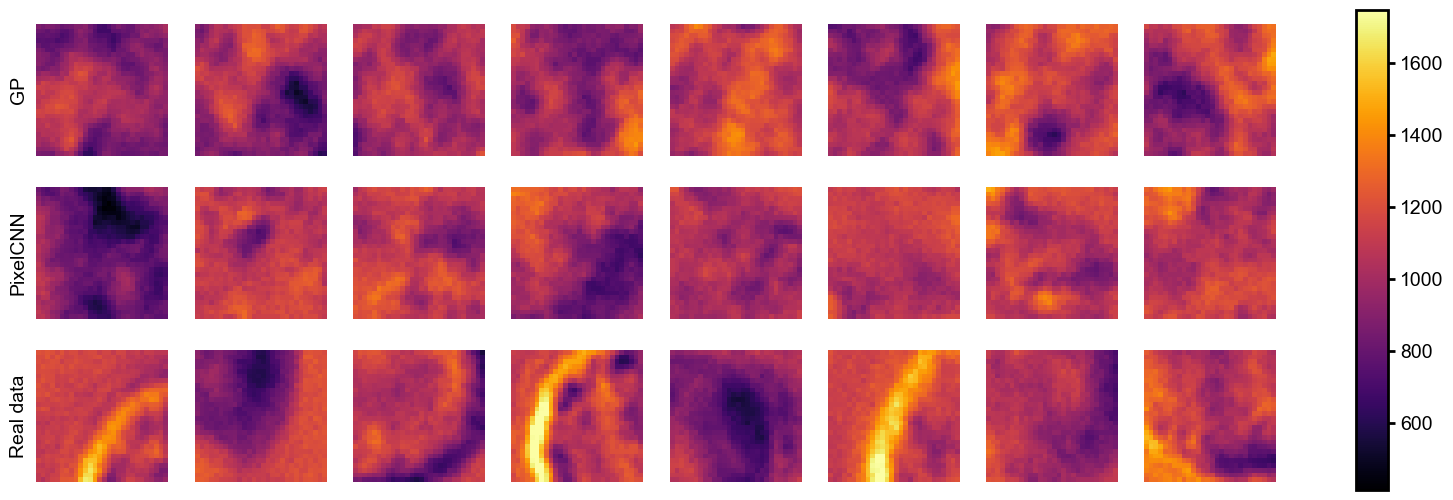

: 

In [53]:
# plot samples
fig, axes = plt.subplots(3, len(gp_samples), figsize=(2 * len(gp_samples), 6))

vmin, vmax = np.percentile(patches, 0.1), np.percentile(patches, 99.9)
# vmin, vmax = np.percentile(gp_samples, 0.5), np.percentile(gp_samples, 99.5)

for i, (gp_sample, pixel_cnn_sample) in enumerate(zip(gp_samples, pixel_cnn_samples)):
    axes[0, i].imshow(gp_sample, cmap='inferno', vmin=vmin, vmax=vmax)
    axes[1, i].imshow(pixel_cnn_sample, cmap='inferno', vmin=vmin, vmax=vmax)
    im = axes[2, i].imshow(test_patches[i], cmap='inferno', vmin=vmin, vmax=vmax)
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')

# add colorbar
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cbar_ax)

# add text to the left side of each row
for i, label in enumerate(['GP', 'PixelCNN', 'Real data']):
    axes[i, 0].text(-0.2, 0.5, label, transform=axes[i, 0].transAxes, va='center', rotation='vertical', fontsize=14)